# 1. Soft SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_iris()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 

# Filter out the rows where y is 2
mask = (y != 2)
X_filtered = X[mask]  # Only keep rows where y is not 2
y_filtered = y[mask]  # Only keep corresponding labels

# Encode y to be +1 and -1
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_encoded[y_encoded == 0] = -1  # Replace 0 with -1

# Now X_filtered contains the features and y_encoded contains the -1 and +1 labels
data_X = X_filtered[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
data_y = y_encoded

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

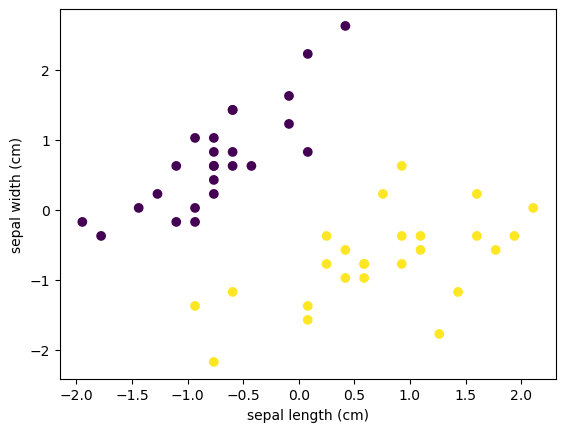

In [4]:
n = 50
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')

In [5]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.legend()
    plt.title('Hard Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['Ground Truth', 'ODE Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.title('SVM Decision Boundaries')
    plt.show()

In [6]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b']
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

Time: 0.11454319953918457
Optimal objective value: 3.509302958519576
SCS solver iterations: 425
SCS solve time: 0.034410271
SCS setup time: 0.041889417
Optimal w:  [ 1.9399641  -1.80420157]
Optimal b:  [0.32852456]
Dual variables (Lagrange multipliers): [ 0.          3.50930227  0.          0.          2.95766995  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.          0.         -0.
  0.          0.         -0.          0.          0.          0.
  0.          0.         -0.          0.          0.          0.55163229
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
Constraints: [-2.3278685   0.00000009 -0.9180326  -1.7704916   0.0000001  -1.2786883
 -1.639344   -1.5409833  -0.9508195  -2.491803   -1.2131145  -2.1311471
 -0.49180314 -3.3770487  -1.8688523

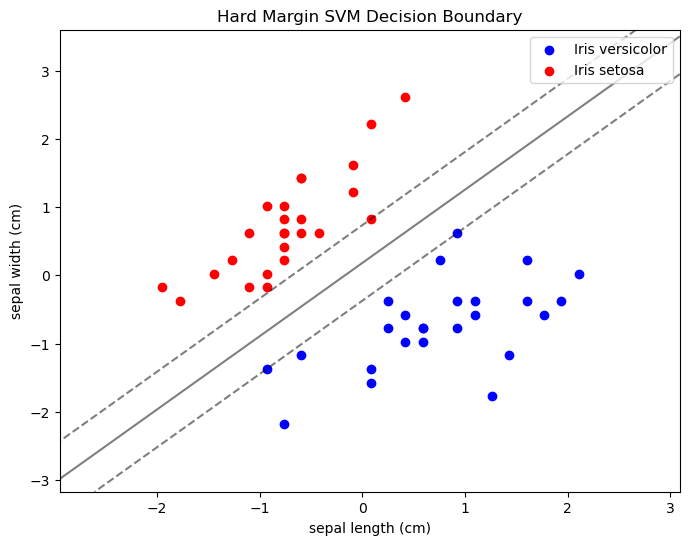

In [7]:
import cvxpy as cp
import numpy as np
import time

C = 10

num_features = selected_X.shape[1]

w = cp.Variable(num_features)
b = cp.Variable(1)
xi = cp.Variable(selected_y.shape[0])

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2 + C * cp.sum(xi))

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1 - xi,
    xi >= 0
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g_1 = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_2 = [np.array([-xi.value[i]]) for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g_1 + g_2).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

In [8]:
nw = selected_X.shape[1]
nb = 1
nxi = selected_y.shape[0]
nx = nw + nb + nxi
nu = selected_X.shape[0] * 2
NY = nx+nu

def f(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    output = (1/2) * jnp.linalg.norm(w, 2)**2 + C * jnp.sum(xi)
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    g_1 = [-selected_y[i] * (w @ selected_X[i] + b) + 1 - xi[i] for i in range(selected_y.shape[0])]
    g_2 = [- xi[i] for i in range(selected_y.shape[0])]
    output = jnp.array(g_1 + g_2)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.02).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj


def constraints_diff(g_ODE, g_SCS):
    return jnp.abs(g_ODE - g_SCS).max()

In [9]:
def solve_ODE(xu0, T):
    sol = solve_ivp(ODE, [0., T], xu0, method=NUMERICAL_METHOD)
    result = P(sol.y[:, -1])
    print("objective:",evalutation(result))
    print("Constraints:",g(result[:nx]))
    diff = constraints_diff(g(result[:nx]), g_SCS)
    print("max diff:", diff.max(), "mean diff:", diff.mean())
    print("w diff:", jnp.abs(result[:nw] - w.value), "b diff:", jnp.abs(result[nw] - b.value))

    return sol, result

In [10]:
g_SCS

Array([-2.3278685 ,  0.00000009, -0.9180326 , -1.7704916 ,  0.0000001 ,
       -1.2786883 , -1.639344  , -1.5409833 , -0.9508195 , -2.491803  ,
       -1.2131145 , -2.1311471 , -0.49180314, -3.3770487 , -1.8688523 ,
       -0.39344248, -1.4426227 , -0.5573769 , -1.934426  , -0.29508185,
       -1.8032784 , -1.9672129 , -1.1803277 , -0.52459   , -2.5901637 ,
       -0.49180314, -2.5245898 , -2.3934424 , -1.3114752 , -2.5245898 ,
       -2.1311471 , -1.7704916 , -2.3278685 , -4.983606  , -2.229508  ,
       -1.8688523 , -1.9999998 , -0.1639343 , -2.0327866 , -1.2786883 ,
       -1.9016391 ,  0.00000007, -3.1147537 , -1.0491802 , -3.8032782 ,
       -3.7704914 , -0.6229507 , -4.229508  , -1.5081965 , -2.3934424 ,
        0.        , -0.00000003, -0.        ,  0.        , -0.00000004,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.  

objective: 3.5144198
Constraints: [-2.3247674   0.0006776  -0.91530555 -1.7672473   0.00057847 -1.2755913
 -1.6358769  -1.5373487  -0.948148   -2.487997   -1.2110677  -2.1277113
 -0.48933375 -3.3717983  -1.8659537  -0.3919676  -1.4388211  -0.5550196
 -1.9304771  -0.29442304 -1.8002685  -1.9644815  -1.1782252  -0.5221764
 -2.5863466  -0.49049625 -2.5206614  -2.3892908  -1.3084339  -2.5208397
 -2.1265497  -1.7684091  -2.3236055  -4.9771543  -2.2262394  -1.8659537
 -1.9961625  -0.16189146 -2.0291836  -1.2755913  -1.8987964   0.00009731
 -3.1100404  -1.046676   -3.7977693  -3.7649267  -0.62070507 -4.22374
 -1.5045063  -2.3892908  -0.00000041 -0.00066119 -0.0000004  -0.00000037
 -0.00058178 -0.0000004  -0.00000037 -0.00000015 -0.00000024 -0.00000016
 -0.00000035 -0.00000016  0.00000046 -0.00000016 -0.00000025  0.00000047
 -0.00000029 -0.00000013 -0.0000002   0.00000031 -0.00000036 -0.00000022
 -0.00000046  0.00000044 -0.00000046 -0.00000034 -0.00000037 -0.00000036
 -0.00000042 -0.00000016 -

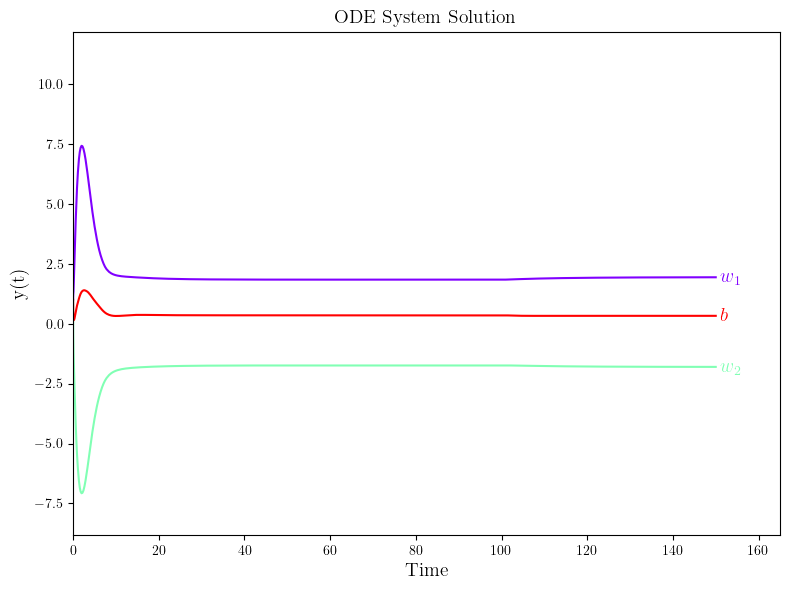

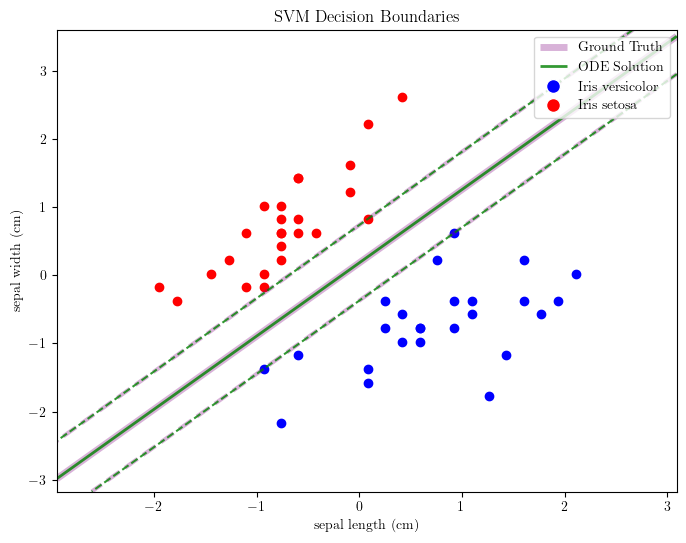

In [11]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nw + nb].set(1.0)

sol, result = solve_ODE(xu0, 150)

t_values = sol.t
y_values = sol.y

w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

plot_ode_system(t_values, y_values)

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)

In [12]:
t0 = time.time()
sol, result = solve_ODE(xu0, 30)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Constraints: [-2.263311    0.02894473 -0.8052257  -1.6565485   0.01359435 -1.1556659
 -1.5061063  -1.3932738  -0.8428365  -2.3880868  -1.1743804  -2.0376468
 -0.379567   -3.2137423  -1.8000389  -0.36066946 -1.2804418  -0.4547848
 -1.7813244  -0.31111535 -1.7248176  -1.912871   -1.1367698  -0.41717488
 -2.4702604  -0.47349805 -2.3950388  -2.2445967  -1.1932766  -2.4256973
 -1.943711   -1.7504842  -2.1693754  -4.8035555  -2.150479   -1.8000389
 -1.8565458  -0.03349582 -1.9248148  -1.1556659  -1.8376495  -0.0179679
 -2.9761345  -0.9556688  -3.6394036  -3.601793   -0.5300057  -4.065065
 -1.3556637  -2.2445967   0.00000408 -0.02909138  0.00000455  0.00000425
 -0.01378351  0.00000429  0.00000374  0.00000418  0.0000044   0.00000408
  0.0000041   0.00000408  0.00000196  0.00000408  0.00000405  0.00000325
  0.00000426  0.00000551  0.00000415  0.00000287  0.000004    0.00000399
  0.0000041   0.00000476  0.00000412  0.00000671  0.00000431  0.00000382
  0.00000414  0.00000408  0.000

In [13]:
t0 = time.time()
sol, result = solve_ODE(xu0, 50)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Constraints: [-2.2432814   0.03175682 -0.79381734 -1.6405648   0.01707912 -1.1421335
 -1.4904495  -1.3778629  -0.831346   -2.3664243  -1.1608042  -2.0181084
 -0.3704427  -3.1862     -1.7823787  -0.35158458 -1.2652766  -0.4455009
 -1.7637079  -0.30349916 -1.7073212  -1.894965   -1.1232754  -0.40797153
 -2.4497836  -0.46417186 -2.3747258  -2.2246106  -1.1796622  -2.4039533
 -1.92438    -1.7342932  -2.149553   -4.767109   -2.1306949  -1.7823787
 -1.8387657  -0.02990003 -1.9055219  -1.1421335  -1.8199077  -0.01500946
 -2.9504702  -0.94393253 -3.6095736  -3.5720448  -0.5205588  -4.0329475
 -1.3403343  -2.2246106  -0.00000041 -0.03173058 -0.0000004  -0.00000037
 -0.01718077 -0.0000004  -0.00000037 -0.00000015 -0.00000024 -0.00000016
 -0.00000035 -0.00000016  0.00000046 -0.00000016 -0.00000025  0.00000047
 -0.00000029 -0.00000013 -0.0000002   0.00000031 -0.00000036 -0.00000022
 -0.00000046  0.00000044 -0.00000046 -0.00000034 -0.00000037 -0.00000036
 -0.00000042 -0.00000016 -0.0

# 3. The method

In [14]:
T=150.0

In [15]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time.time()-t0

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        return dynamics_loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [16]:
y0 = np.zeros(NY)
y0[:nw + nb] = 1.0

In [17]:
def try_layers(l_list, n, lr):
     NEURONS = n
     LR = lr
     res = []
     for l in l_list:
          LAYERS = l
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_neurons(n_list, l, lr):
     LAYERS = l
     LR = lr
     res = []
     for n in n_list:
          NEURONS = n
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_lr(lr_list, l, n):
     LAYERS = l
     NEURONS = n
     res = []
     for lr in lr_list:
          LR = lr
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def plot_results(res, y_max=50):
    fig, axes = plt.subplots(1, len(res), figsize=(20, 6))
    y_min = 0
    for i in range(len(res)):
        # Plot on the first subplot
        axes[i].plot(res[i]['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
        axes[i].plot(res[i]['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
        axes[i].set_xlabel('iteration')
        axes[i].set_ylabel('OuC metric')
        axes[i].set_title(f'l={res[i]["layers"]}, n={res[i]["neurons"]}, lr={res[i]["lr"]}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_xlim(0, ITERATIONS)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plot
    plt.show()

def plot_result_confrontation(res):
     plt.figure(figsize=(6, 5))
     for r in res:
          plt.plot(r['L_epsilon'], marker='o', linestyle='-', label=f'l={r["layers"]}, n={r["neurons"]}, lr={r["lr"]}', markersize=1)
     # Add labels, title, legend and grid
     plt.xlabel('iteration')
     plt.ylabel('OuC metric')
     plt.title('Numbers of layers')
     plt.legend()  # Show the legend to distinguish the datasets
     plt.grid(False)
     plt.show()

def plot_hyperplane(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     w_net = epsilon[0][:selected_X.shape[1]]
     b_net = epsilon[0][selected_X.shape[1]]
     # Plotting
     plt.figure(figsize=(10, 8))
     plt.scatter(selected_X[selected_y > 0][:, 0], selected_X[selected_y > 0][:, 1], c='b', label='Class 1')
     plt.scatter(selected_X[selected_y < 0][:, 0], selected_X[selected_y < 0][:, 1], c='r', label='Class -1')

     # Plot the decision boundary
     x_min, x_max = selected_X[:, 0].min() - 1, selected_X[:, 0].max() + 1
     y_min, y_max = selected_X[:, 1].min() - 1, selected_X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
     Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_net) + b_net
     Z = Z.reshape(xx.shape)
     plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

     # Plot the margins
     plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])

     plt.xlabel('Feature 1')
     plt.ylabel('Feature 2')
     plt.legend()
     plt.title('Hard Margin SVM Decision Boundary')
     plt.show()

def print_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     # Print the absolute differences for all weights and bias
     print('w absolute differences:', w_abs_diff)
     print('b absolute difference:', b_abs_diff)

     # Print the MSE
     print('\nMSE between the two solutions:', mse_)

def get_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]], dtype=torch.float32).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     return mse_

In [18]:
def plot_svm_decision_boundary_confrontation_PINN(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['ODE Solution', 'PINN Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.title('SVM Decision Boundaries')
    plt.show()

LAYERS: 1 NEURONS: 100 LR: 0.01 epsilon: 737.44354 MSE solution: 8.53730873298464 time: 449.8845708370209
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1045.3103 MSE solution: 5.2628473266106175 time: 386.00020146369934
LAYERS: 3 NEURONS: 100 LR: 0.01 epsilon: 1135.4093 MSE solution: 4.477060456260783 time: 380.55206632614136
LAYERS: 4 NEURONS: 100 LR: 0.01 epsilon: 710.4565 MSE solution: 3.438746669387077 time: 381.8023180961609
LAYERS: 5 NEURONS: 100 LR: 0.01 epsilon: 448.8948 MSE solution: 5.177803145256346 time: 380.79852509498596


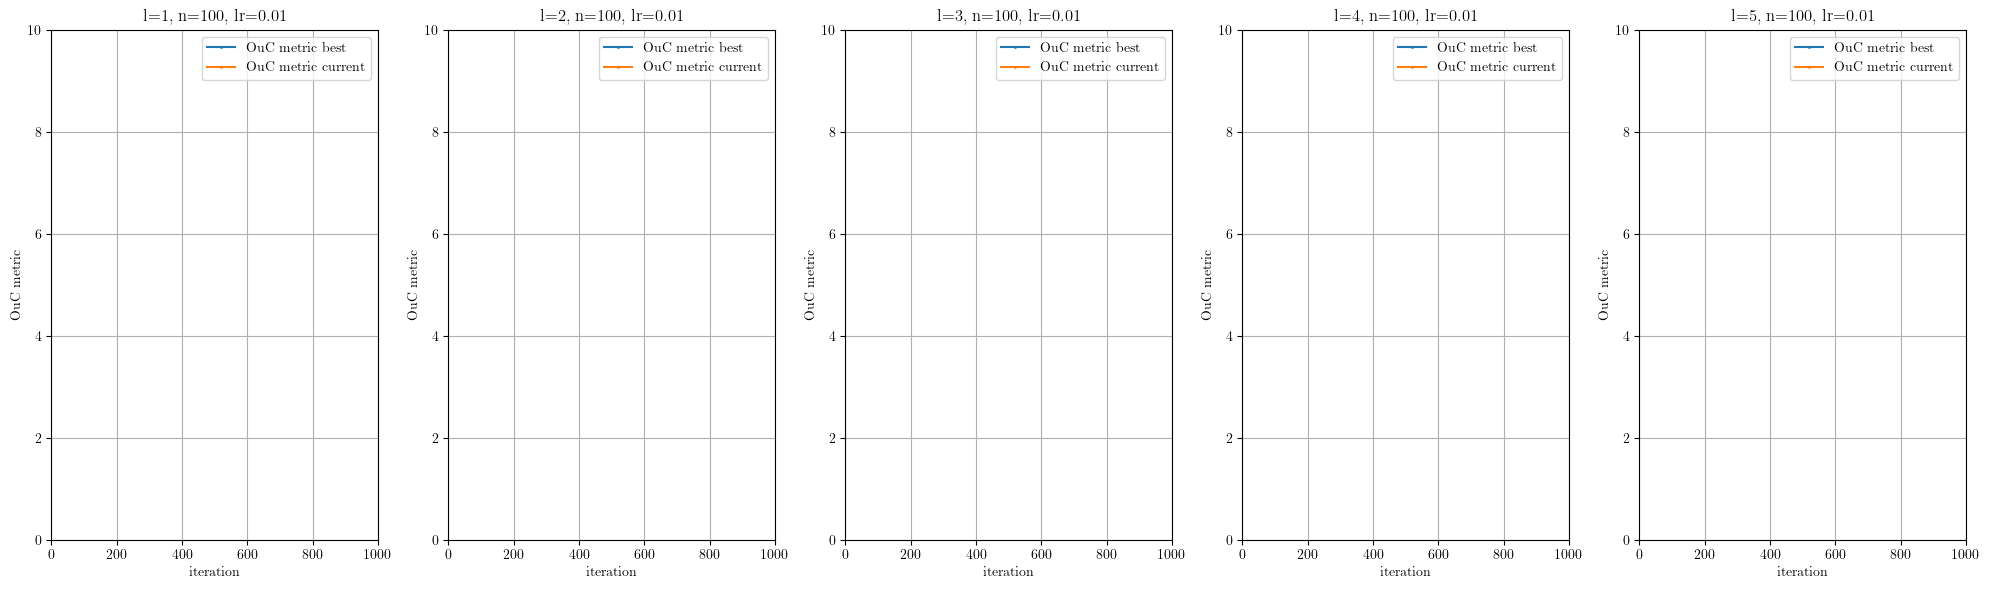

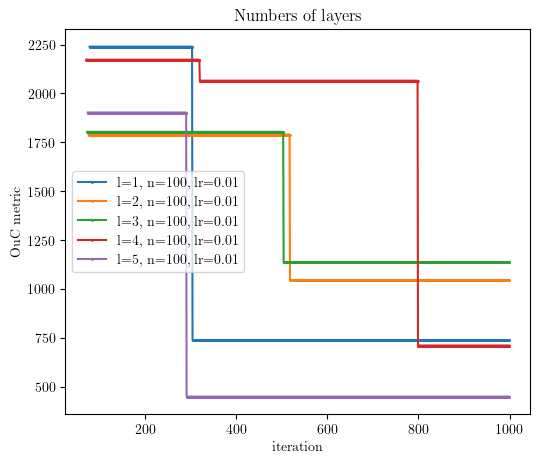

In [19]:
NBATCH = 512
ITERATIONS = 1000
WEIGTHING = 3
NEURONS=100
LR=0.01
LAYERS=2
res_layers = try_layers([1, 2, 3, 4, 5], 100, 0.01)
plot_results(res_layers, y_max=10)
plot_result_confrontation(res_layers)

LAYERS: 2 NEURONS: 50 LR: 0.01 epsilon: 358.95578 MSE solution: 7.327598171341968 time: 382.2621567249298
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 301.22974 MSE solution: 4.679454347392308 time: 376.0452892780304
LAYERS: 2 NEURONS: 200 LR: 0.01 epsilon: 763.8521 MSE solution: 10.02199820516176 time: 379.96070861816406
LAYERS: 2 NEURONS: 300 LR: 0.01 epsilon: 994.75134 MSE solution: 9.034309000406333 time: 376.15672183036804
LAYERS: 2 NEURONS: 400 LR: 0.01 epsilon: 1193.7267 MSE solution: 4.10955841156242 time: 382.2310416698456


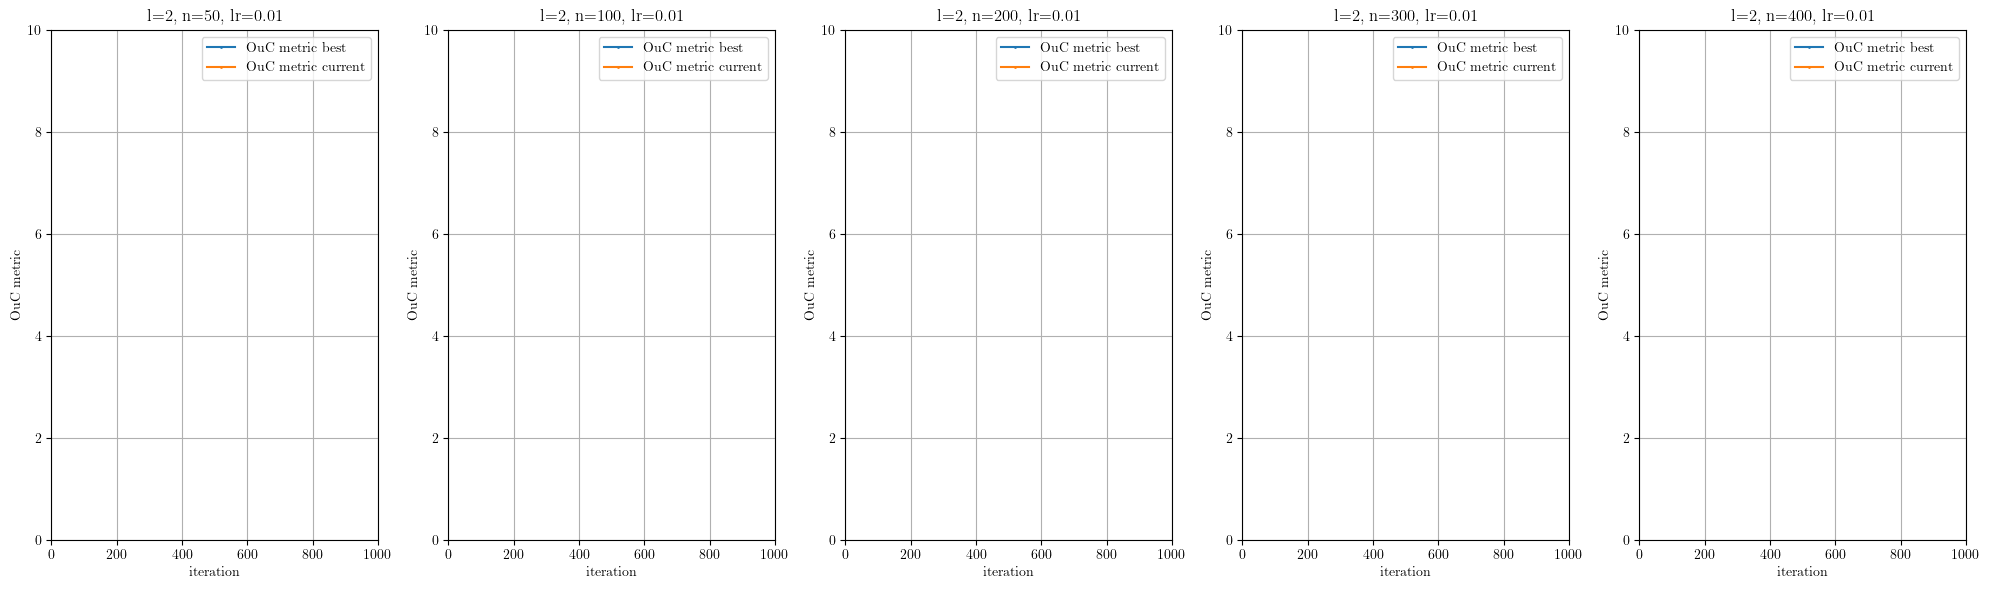

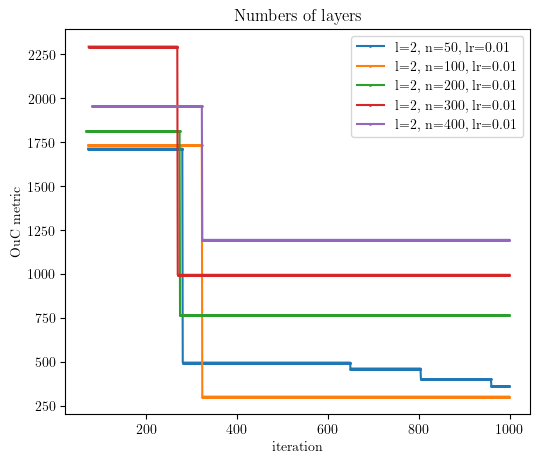

In [20]:
res_neurons = try_neurons([50, 100, 200, 300, 400], 2, 0.01)
plot_results(res_neurons, y_max=10)
plot_result_confrontation(res_neurons)

LAYERS: 2 NEURONS: 100 LR: 0.0001 epsilon: 714.6063 MSE solution: 3.4809804389181505 time: 379.9834883213043
LAYERS: 2 NEURONS: 100 LR: 0.001 epsilon: 282.47952 MSE solution: 18.692878149480357 time: 380.4017927646637
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 437.76907 MSE solution: 11.707365257147798 time: 387.4470760822296
LAYERS: 2 NEURONS: 100 LR: 0.1 epsilon: 1254.9236 MSE solution: 1.8311073943557874 time: 384.2290892601013


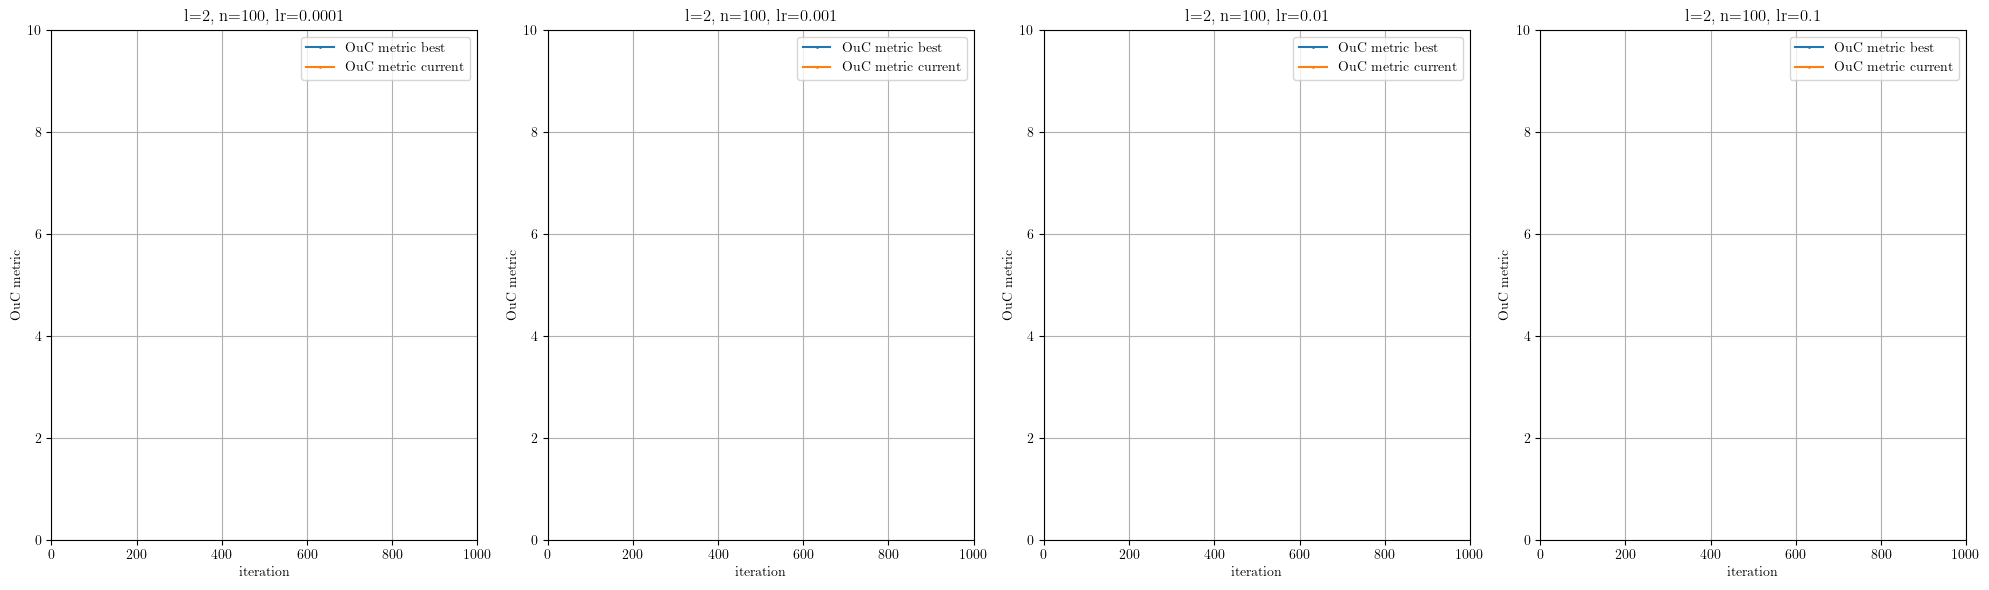

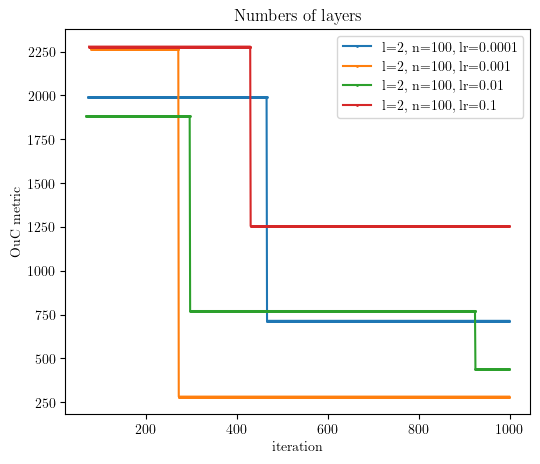

In [21]:
res_learning_rate = try_lr([0.0001, 0.001, 0.01, 0.1], 2, 100)
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

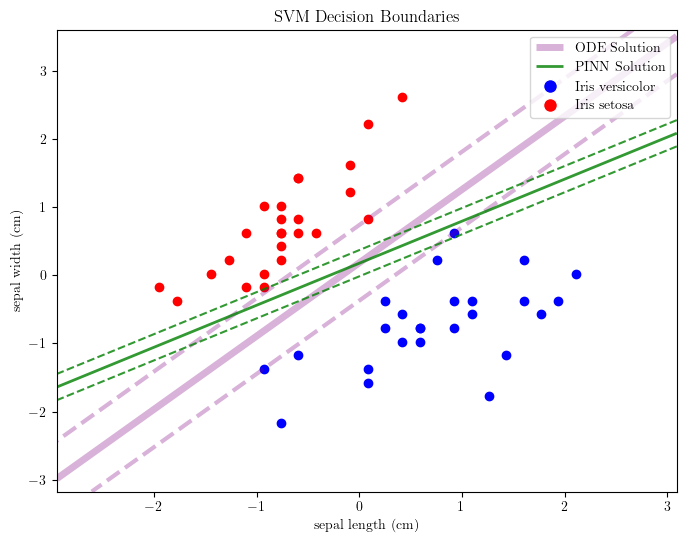

Variables: [ 3.2017846  -5.1915693   0.9166095   2.7304077   0.21620634  2.285008
  2.8653548   1.5593888   2.6784089   2.728374    2.6882424   2.4104795
  2.5036035   2.5406697   2.6351893   0.9027407   2.48755     2.6395233
  0.35814273  2.6983695   0.99684715  2.67469     0.54415286  2.7290854
  2.8085623   2.4434805   1.0207062   2.9576514   0.5305653   2.8646293
  2.7278593   2.746878    2.6557252   2.4788127   2.7050045   2.6521955
  2.5612047   2.667255    2.6951113   2.6554625   0.78873974  2.614776
  2.6819308   2.8081617   0.021888    2.5786757   2.3620355   2.5553696
  2.6112545   1.6573046   2.528093    2.6541307   2.7748423 ]
Constraints: [-11.084485    -2.3155208   -5.014388    -9.656926    -1.2034878
  -6.4455714   -7.5333195   -6.003218    -5.636516    -8.9155245
  -7.284743    -8.009328    -1.6010251   -9.03288     -8.465849
  -1.5366809   -4.523376    -2.6884444   -7.524105    -4.65816
  -7.5620975  -10.124857    -6.690897    -2.215647   -13.314757
  -3.199073   -12.2

In [22]:
net = res_layers[2]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

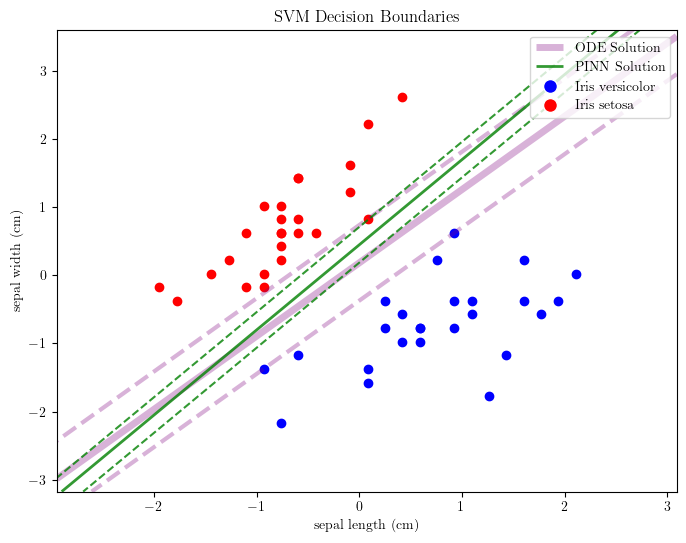

Variables: [ 4.7752147  -3.8226209   1.708374    0.43177226  3.0929503   0.26978183
  0.20186985  0.09006518  0.14497055  0.20982227  0.29009748  0.6207057
  0.23637947  0.5574362   0.14933367  1.4043694   0.24274847  0.40373102
  1.3122464   0.35263222  1.1605221   0.28329337  1.6197382   0.12649399
  0.41236496  0.6777826   1.2347565   0.55336475  1.5172533   0.41702774
  0.28207695  0.39041194  0.28090745  0.2170298   0.41828203  0.17663583
  0.2075441   0.28597873  0.32070553  0.08372694  1.7924607   0.13887545
 -0.00676943  0.26013678  2.3360019   0.2845357   0.65139073  0.20726682
  0.20419164  1.0195774   0.03397115  0.41618663  0.23758325]
Constraints: [ -7.5488977   -3.1454215   -2.8292265   -4.117921    -2.8369668
  -3.4685483   -4.297533    -4.5065527   -3.1372354   -8.375127
  -5.4250774   -7.523948    -3.2855108  -10.931385    -6.885468
  -4.780366    -4.697832    -2.9558337   -5.220967    -3.9804058
  -6.694061    -6.7653575   -5.588339    -3.072983    -5.8689375
  -4.856

In [23]:
net = res_neurons[1]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

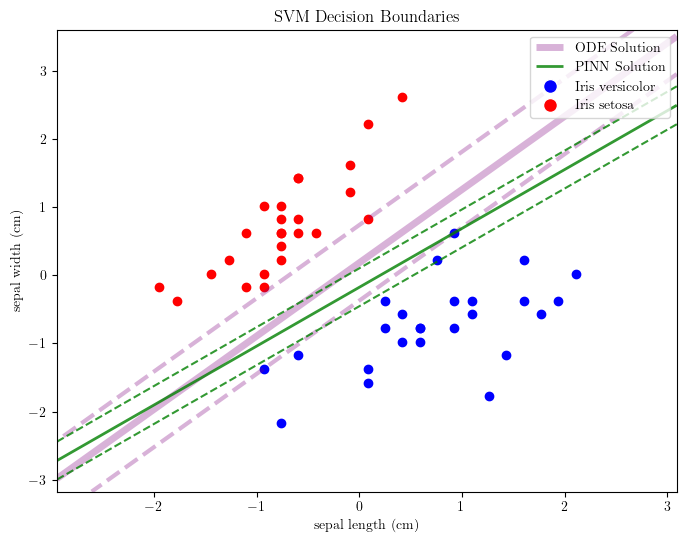

Variables: [ 3.1031675  -3.5931096  -0.63457406  2.9620948   0.7234821   2.8236785
  3.054673    1.0740784   2.8274953   2.8641357   2.623529    2.9134505
  2.5658028   2.9024897   2.5659773   1.8433107   2.5201828   2.8517983
  1.3073689   2.7134335   2.1033235   2.5754342   0.99134064  2.6735237
  3.0339365   2.7846346   1.9963866   3.2470157   1.2286127   3.1732786
  2.8945866   2.9438357   2.5639894   2.6529891   3.1899443   2.744509
  2.56443     2.8405907   2.8619545   2.8282356   1.2216902   2.649045
  2.8614001   2.9054248   0.63795316  2.5992975   2.939236    2.5805876
  2.6567495   2.2157683   2.5325625   2.760036    2.7760649 ]
Constraints: [ -7.2391047   -3.0655234   -6.3515067   -8.79419     -0.07258709
  -7.073578    -7.8284726   -7.00648     -6.635074    -6.3982964
  -4.8309417   -5.6802163   -4.2652946   -7.3446684   -5.829169
  -1.217927    -6.5149994   -4.9128976   -7.870435    -1.7340056
  -5.2633038   -6.5926924   -4.5192914   -4.6121655  -11.004427
  -1.7205561  -1

In [24]:
net = res_learning_rate[3]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

In [25]:
LAYERS = 2
NEURONS = 100
LR = 0.01
import time
example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, t = example.NN_method() # train
mse_ = get_error({'net': net_best})
print('LAYERS:', LAYERS, 'NEURONS:', NEURONS, 'LR:', LR, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', t)
res = {'layers': LAYERS, 'neurons': NEURONS, 'lr': LR, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time}


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 303.26044 MSE solution: 11.586985983312964 time: 379.89594984054565


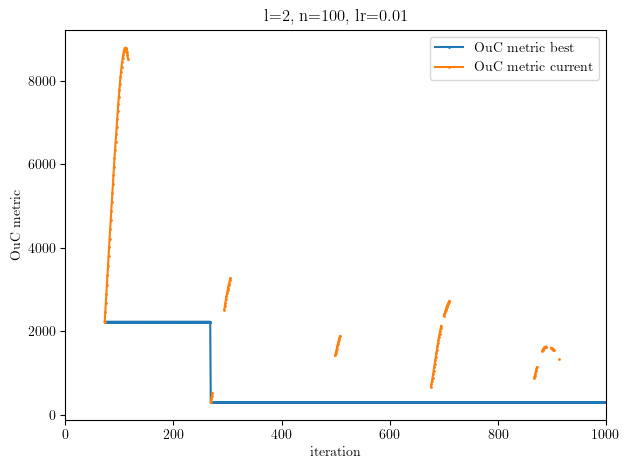

In [26]:
plt.plot(res['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
plt.plot(res['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title(f'l={res["layers"]}, n={res["neurons"]}, lr={res["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)

plt.tight_layout()
# Show the plot
plt.show()

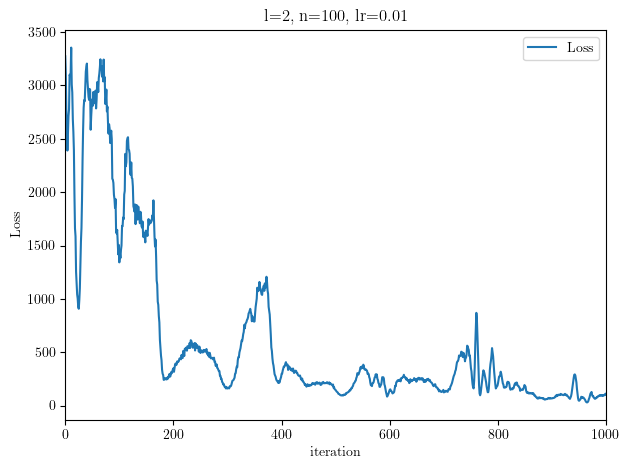

In [27]:

plt.plot(L_loss, label='Loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title(f'l={res["layers"]}, n={res["neurons"]}, lr={res["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)
plt.tight_layout()
# Show the plot
plt.show()

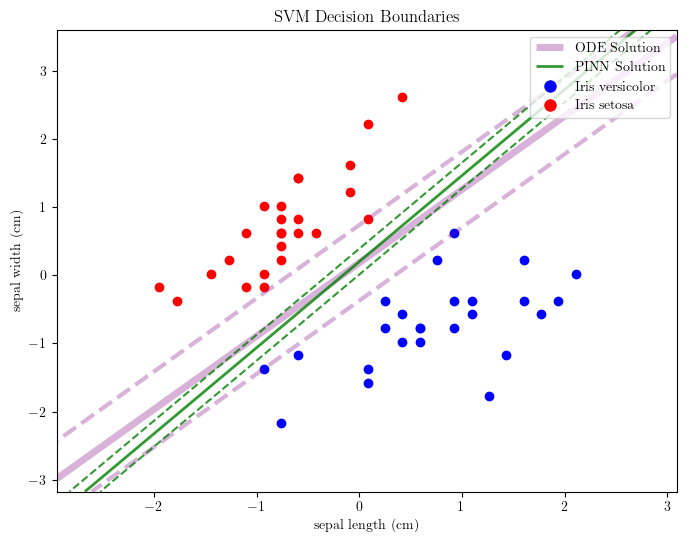

Variables: [ 6.651697   -5.267983    1.0539224   1.2315092   2.5555377   0.3858545
  0.43853107  0.35288927  0.23761003  0.24128832  0.43734267  0.6496638
  0.18151206  0.8997561   0.19165921  0.5903338   0.2341258   0.3256098
  0.27294147  0.43496153  1.0544417   0.44366303  1.4650984   0.5783215
  0.5280704   0.6254132   0.7156068   0.41835144  1.2117995   0.57714266
  0.29674178  0.33813113  0.39354903  0.12305047  0.8541478   0.11608507
  0.04268277  0.655968    0.33130306  0.12563431  1.2320111   0.10706662
  0.25875425  0.6207134   0.73625743  0.04589614  0.9882824   0.21085683
  0.330525    1.0822996   0.199626    0.13421027  0.22337899]
Constraints: [-10.123136    -4.3006024   -5.6457434   -7.520014    -3.2818215
  -6.550556    -7.607292    -8.016738    -5.8384223  -10.552978
  -6.70334     -9.510067    -4.9394255  -14.1915455   -8.377569
  -4.183801    -8.227747    -5.261273    -9.004985    -3.753858
  -8.772542    -8.366639    -6.5001273   -4.9935684   -9.392558
  -4.9092684 

In [28]:
net = res['net']
res_ = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res_[:data_X.shape[1]], res_[data_X.shape[1]], 0, 1)
print('Variables:', res_[:nx])
print('Constraints:', g(res_[:nx]))